# Purpose

2022-02
After fixing the parallel jobs, we need to pick the best model to share on bigQuery and to use for new FPRs.


# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook



print_lib_versions([hydra, np, pd, plotly, sns, subclu])

python		v 3.7.11
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.4.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [5]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////Users/david.bermejo/repos/subreddit_clustering_i18n/mlflow_sync/C02FD08QMD6V/mlruns.db'

## Get list of experiments with new function

In [6]:
mlf.list_experiment_meta(output_format='pandas').tail(9)

,experiment_id,name,artifact_location,lifecycle_stage
17,17,v0.4.0_use_multi_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/17,active
18,18,v0.4.0_use_multi_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/18,active
19,19,v0.4.1_mUSE_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/19,active
20,20,v0.4.1_mUSE_inference,gs://i18n-subreddit-clustering/mlflow/mlruns/20,active
21,21,v0.4.1_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/21,active
22,22,v0.4.1_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/22,active
23,23,v0.4.1_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/23,active
24,24,v0.4.1_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/24,active
25,25,v0.4.1_mUSE_clustering_new_metrics,gs://i18n-subreddit-clustering/mlflow/mlruns/25,active


## Get experiment ID's for models to check

experiment ID 25 as the latest runs

In [7]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[25])
df_mlf.shape

CPU times: user 1.32 s, sys: 46.4 ms, total: 1.37 s
Wall time: 1.37 s


(132, 273)

In [8]:
df_mlf.iloc[:5, :10]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.primary_topic-0020_to_0040-precision-weighted_avg,metrics.primary_topic-1700_to_2000-recall-weighted_avg,metrics.primary_topic-0750_to_1000-adjusted_mutual_info_score,metrics.primary_topic-0040_to_0050-adjusted_rand_score
0,a6ee2f75491d4449a05fad502d7b80c3,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/a6ee2f75491d4449a05fad502d7b80c3/artifacts,2022-01-20 19:50:19.553000+00:00,2022-01-20 19:54:40.237000+00:00,0.223732,0.422591,0.264373,0.270185
1,4b246da72d254bf9888962d483ed49a3,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/4b246da72d254bf9888962d483ed49a3/artifacts,2022-01-20 19:49:26.745000+00:00,2022-01-20 20:02:40.384000+00:00,0.193544,0.542342,0.141097,0.000166
2,619e29db458a43e6ac726eac7145db89,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/619e29db458a43e6ac726eac7145db89/artifacts,2022-01-20 19:49:09.043000+00:00,2022-01-20 19:53:31.024000+00:00,0.239758,0.421829,0.264794,0.336417
3,25c5dfaa03d34da88fdfb3a1850d7d44,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/25c5dfaa03d34da88fdfb3a1850d7d44/artifacts,2022-01-20 19:48:44.509000+00:00,2022-01-20 20:02:25.618000+00:00,0.193851,0.526495,0.067688,0.000171
4,b29776a461994e00b00139ec1bb6270b,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/b29776a461994e00b00139ec1bb6270b/artifacts,2022-01-20 19:46:49.578000+00:00,2022-01-20 19:51:15.689000+00:00,0.246098,0.419423,0.265473,0.351944


In [9]:
mask_finished = df_mlf['status'] == 'FINISHED'
mask_df_similarity_complete = ~df_mlf['metrics.primary_topic-2350_to_2700-f1_score-weighted_avg'].isnull()

df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
df_mlf_clustering_candidates.shape

(132, 273)

In [10]:
cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]
print(f"interesting cols: {len(cols_with_multiple_vals)}")
df_mlf_clustering_candidates[cols_with_multiple_vals].iloc[:5, :10]

interesting cols: 244


,run_id,artifact_uri,start_time,end_time,metrics.primary_topic-0020_to_0040-precision-weighted_avg,metrics.primary_topic-1700_to_2000-recall-weighted_avg,metrics.primary_topic-0750_to_1000-adjusted_mutual_info_score,metrics.primary_topic-0040_to_0050-adjusted_rand_score,metrics.primary_topic-1000_to_1350-homogeneity_score,metrics.primary_topic-2000_to_2350-adjusted_rand_score
0,a6ee2f75491d4449a05fad502d7b80c3,gs://i18n-subreddit-clustering/mlflow/mlruns/25/a6ee2f75491d4449a05fad502d7b80c3/artifacts,2022-01-20 19:50:19.553000+00:00,2022-01-20 19:54:40.237000+00:00,0.223732,0.422591,0.264373,0.270185,0.228267,0.408543
1,4b246da72d254bf9888962d483ed49a3,gs://i18n-subreddit-clustering/mlflow/mlruns/25/4b246da72d254bf9888962d483ed49a3/artifacts,2022-01-20 19:49:26.745000+00:00,2022-01-20 20:02:40.384000+00:00,0.193544,0.542342,0.141097,0.000166,0.135006,0.443376
2,619e29db458a43e6ac726eac7145db89,gs://i18n-subreddit-clustering/mlflow/mlruns/25/619e29db458a43e6ac726eac7145db89/artifacts,2022-01-20 19:49:09.043000+00:00,2022-01-20 19:53:31.024000+00:00,0.239758,0.421829,0.264794,0.336417,0.226166,0.396787
3,25c5dfaa03d34da88fdfb3a1850d7d44,gs://i18n-subreddit-clustering/mlflow/mlruns/25/25c5dfaa03d34da88fdfb3a1850d7d44/artifacts,2022-01-20 19:48:44.509000+00:00,2022-01-20 20:02:25.618000+00:00,0.193851,0.526495,0.067688,0.000171,0.173688,0.350438
4,b29776a461994e00b00139ec1bb6270b,gs://i18n-subreddit-clustering/mlflow/mlruns/25/b29776a461994e00b00139ec1bb6270b/artifacts,2022-01-20 19:46:49.578000+00:00,2022-01-20 19:51:15.689000+00:00,0.246098,0.419423,0.265473,0.351944,0.228004,0.400253


# Pick primary metric cols for evaluation & visualize in parallel coordinates plot

We want to keep the model that:
- has the highest metric scores
- covers the largest number of subreddits (rows)

One hyperparameter while creating clusters is filtering out subreddits with too few posts (min posts). Sometimes these can add noise and impact clustering upstream.

params:
- linkage type
- number of subreddits (rows) after filtering
 
metrics:
- Optimal clusters to check:
    - @ 3000 to 3200
    - @ 3900 to 4000
- metrics
    - f1 weighted
    - adjusted mutual info
    - adjusted rand score
    - homogeneity

In [80]:
def rename_col_for_display(
    col_name: str,
) -> str:
    """
    Remove prefixes & other extra characters to columns so 
    that it's easier to read/display them in plots & tables
    """
    return (
        col_name
        .replace('metrics.primary_topic-', '')
        .replace('00-', '00<br>')  # split cols into 2 rows after num of clusters (k)
        .replace('filtered_embeddings-n_rows', 'subreddits')  # subreddits clustered
        .replace('score', 'score<br>') # add an extra break after avg & score to improve look of plots
        .replace('_avg', '_avg<br>')
        .replace('metrics.', '')
        .replace('params.', '')
        .replace('_pipe-', '')
        .replace('__', '_')
        .replace('_', ' ')
    )

In [81]:
sorted([c for c in df_mlf_clustering_candidates.columns if 'link' in c])

['params._pipe-cluster__linkage']

In [82]:
sorted([c for c in df_mlf_clustering_candidates.columns if 'row' in c])

['metrics.filtered_embeddings-n_rows',
 'metrics.input_embeddings-n_rows',
 'params.n_sample_embedding_rows']

In [83]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '3000' in c])

In [84]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '4000' in c])

In [85]:
sorted([rename_col_for_display(c) for c in df_mlf_clustering_candidates.columns if '4000' in c])

['3900 to 4000<br>adjusted mutual info score<br>',
 '3900 to 4000<br>adjusted rand score<br>',
 '3900 to 4000<br>f1 score<br>-macro avg<br>',
 '3900 to 4000<br>f1 score<br>-weighted avg<br>',
 '3900 to 4000<br>homogeneity score<br>',
 '3900 to 4000<br>precision-macro avg<br>',
 '3900 to 4000<br>precision-weighted avg<br>',
 '3900 to 4000<br>recall-macro avg<br>',
 '3900 to 4000<br>recall-weighted avg<br>',
 'optimal k-3900 to 4000']

In [86]:
# [c for c in df_mlf_clustering_candidates.columns if 'metric' in c][-15:]

For now forget linkage type, there's some weird thing where you can't show text or category dtypes in a parallel coordinate plot (unless you convert the values to numbers).
- https://github.com/plotly/plotly.py/issues/2494

Looks like you could use the lower-level `go.Parcoords` to do it, but at this point that's too much for me (maybe this is what mlflow uses under the hood?).
- https://plotly.com/python/parallel-coordinates-plot/#parallel-coordinates-chart-with-goparcoords


---
NOTE: plotly uses a df's index, so make sure to reset index b/c otherwise we can end up with weird results!

In [87]:

l_parallel_params = [
    'metrics.filtered_embeddings-n_rows',
    'params._pipe-cluster__linkage',
]

l_parallel_metrics_3k = [
    'metrics.primary_topic-3000_to_3200-homogeneity_score',
    'metrics.primary_topic-3000_to_3200-adjusted_mutual_info_score',
    'metrics.primary_topic-3000_to_3200-adjusted_rand_score',
    'metrics.primary_topic-3000_to_3200-f1_score-weighted_avg',
]
l_parallel_metrics_4k = [
    'metrics.primary_topic-3900_to_4000-homogeneity_score',
    'metrics.primary_topic-3900_to_4000-adjusted_mutual_info_score',
    'metrics.primary_topic-3900_to_4000-adjusted_rand_score',
    'metrics.primary_topic-3900_to_4000-f1_score-weighted_avg',
]

l_parallel_metrics_all = l_parallel_metrics_3k + l_parallel_metrics_4k

In [88]:
df_mlf_clustering_candidates['params._pipe-cluster__linkage'].value_counts()

ward        36
single      32
average     32
complete    32
Name: params._pipe-cluster__linkage, dtype: int64

In [89]:
d_linkage_to_num = {
    'ward': 4,
    'average': 3,
    'complete': 2,
    'single': 1,
}
d_num_to_linkage = {v: k for k, v in d_linkage_to_num.items()}
d_num_to_linkage

{4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}

Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


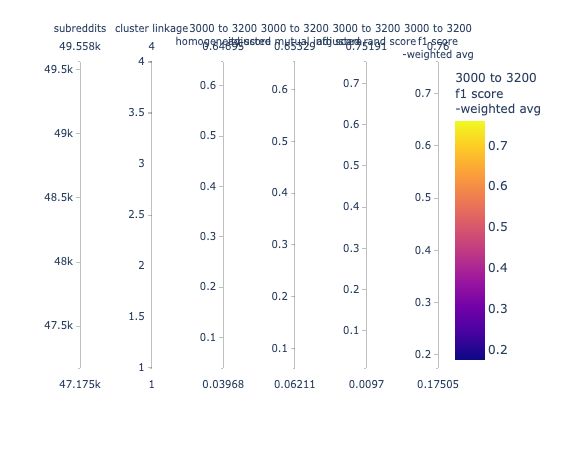

In [90]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

Plot one w/o subreddits to we can show it in slides

Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


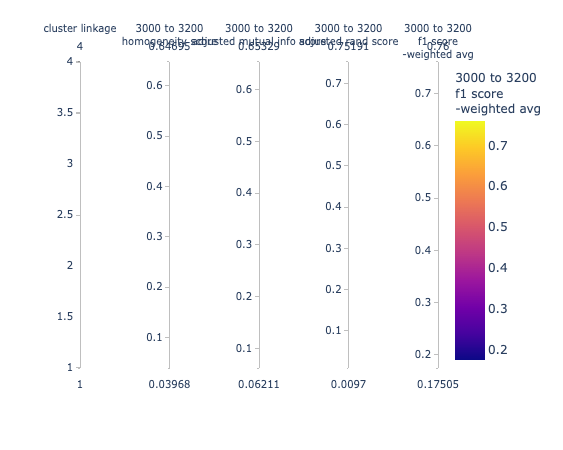

In [97]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")

df_plot_ = df_plot_.drop('subreddits', axis=1)
fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


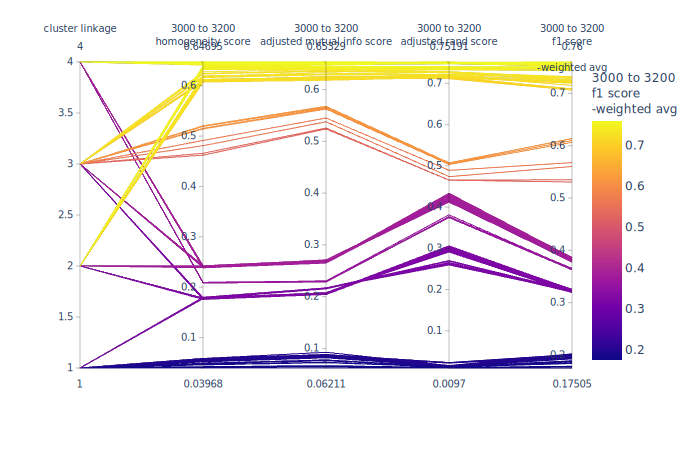

In [100]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")

df_plot_ = df_plot_.drop('subreddits', axis=1)
fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show(renderer='svg')

In [ ]:
# l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_4k
# l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
# (
#     df_mlf_clustering_candidates[l_cols_plot_raw_]
#     .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
#     .reset_index(drop=True)
# )
# # remap cluster linkage so it shows up in plot
# col_linkage_clean = ['cluster linkage']
# df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
# print(f"Linkage names:\n {d_num_to_linkage}")

# fig = px.parallel_coordinates(
#     df_plot_,
#     color=l_cols_plot_clean_[-1],
#     # dimensions=l_cols_plot_clean_,
#     # labels={},
#     # color_continuous_scale=px.colors.diverging.Tealrose,
#     # color_continuous_midpoint=2
# )
# fig.show()

Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


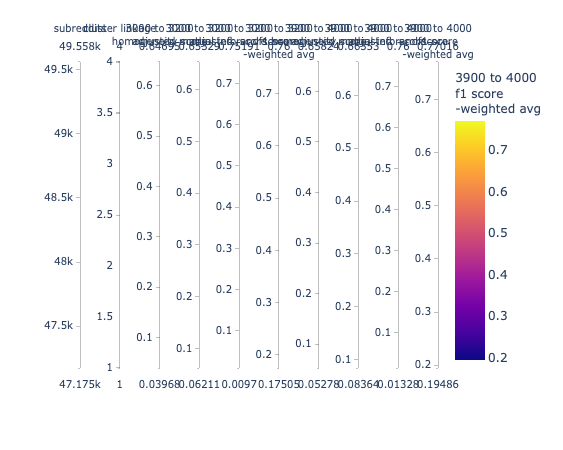

In [91]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")


fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

### Filter to only runs with over 49k rows

Since these are the ones we'll care about the most

(36, 10)
Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


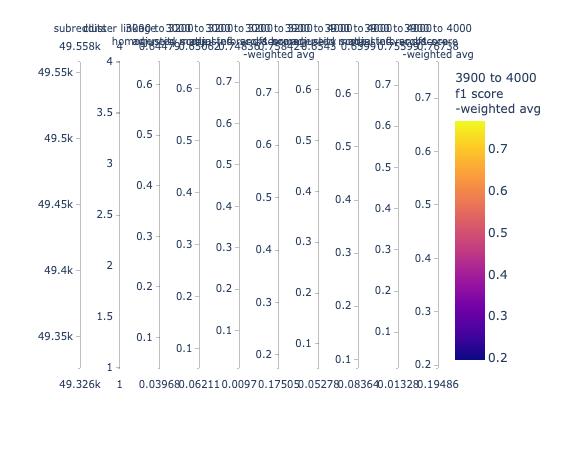

In [92]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [df_mlf_clustering_candidates['metrics.filtered_embeddings-n_rows'] >= 49000]
    [l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
print(df_plot_.shape)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")


fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

(4, 10)
Linkage names:
 {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}


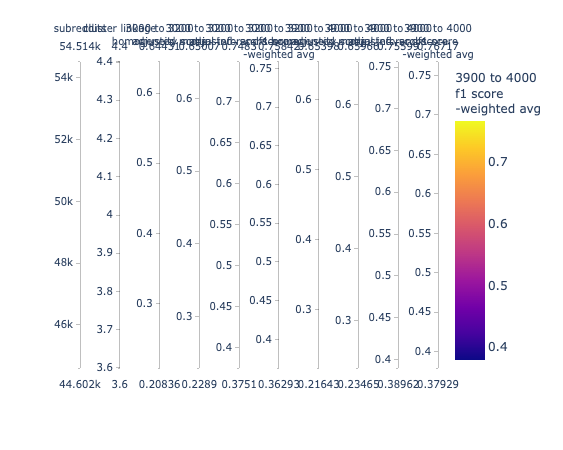

In [99]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [df_mlf_clustering_candidates['metrics.filtered_embeddings-n_rows'] >= 49500]
    [l_cols_plot_raw_]
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
print(df_plot_.shape)
# remap cluster linkage so it shows up in plot
col_linkage_clean = ['cluster linkage']
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
print(f"Linkage names:\n {d_num_to_linkage}")


fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

## Create masks to find top runs

In [94]:
mask_max_subreddits = (
    df_mlf_clustering_candidates['metrics.filtered_embeddings-n_rows'] >= 49400
)

mask_top_metrics = (
    (df_mlf_clustering_candidates['metrics.primary_topic-3000_to_3200-f1_score-weighted_avg'] >= 0.745) &
    (df_mlf_clustering_candidates['metrics.primary_topic-3900_to_4000-f1_score-weighted_avg'] >= 0.745) 
)

print((mask_max_subreddits & mask_top_metrics).sum())

4


In [95]:
l_cols_to_drop = [
    'artifact_uri',
    'start_time',
    'end_time',
]

l_cols_to_drop = (
    l_cols_to_drop + 
    [c for c in cols_with_multiple_vals if 'metrics.memory_' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.model_fit' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.optimal_k' in c]
)

In [96]:
(
    df_mlf_clustering_candidates
    [mask_max_subreddits & mask_top_metrics]
    .sort_values(by=l_cols_plot_raw_[::-1][:-2], ascending=False)
    [sorted(cols_with_multiple_vals)]
    .drop(l_cols_to_drop, axis=1)
)

,metrics.filtered_embeddings-n_rows,metrics.primary_topic-0010_to_0020-adjusted_mutual_info_score,metrics.primary_topic-0010_to_0020-adjusted_rand_score,metrics.primary_topic-0010_to_0020-f1_score-macro_avg,metrics.primary_topic-0010_to_0020-f1_score-weighted_avg,metrics.primary_topic-0010_to_0020-homogeneity_score,metrics.primary_topic-0010_to_0020-precision-macro_avg,metrics.primary_topic-0010_to_0020-precision-weighted_avg,metrics.primary_topic-0010_to_0020-recall-macro_avg,metrics.primary_topic-0010_to_0020-recall-weighted_avg,metrics.primary_topic-0020_to_0040-adjusted_mutual_info_score,metrics.primary_topic-0020_to_0040-adjusted_rand_score,metrics.primary_topic-0020_to_0040-f1_score-macro_avg,metrics.primary_topic-0020_to_0040-f1_score-weighted_avg,metrics.primary_topic-0020_to_0040-homogeneity_score,metrics.primary_topic-0020_to_0040-precision-macro_avg,metrics.primary_topic-0020_to_0040-precision-weighted_avg,metrics.primary_topic-0020_to_0040-recall-macro_avg,metrics.primary_topic-0020_to_0040-recall-weighted_avg,metrics.primary_topic-0040_to_0050-adjusted_mutual_info_score,metrics.primary_topic-0040_to_0050-adjusted_rand_score,metrics.primary_topic-0040_to_0050-f1_score-macro_avg,metrics.primary_topic-0040_to_0050-f1_score-weighted_avg,metrics.primary_topic-0040_to_0050-homogeneity_score,metrics.primary_topic-0040_to_0050-precision-macro_avg,metrics.primary_topic-0040_to_0050-precision-weighted_avg,metrics.primary_topic-0040_to_0050-recall-macro_avg,metrics.primary_topic-0040_to_0050-recall-weighted_avg,metrics.primary_topic-0050_to_0060-adjusted_mutual_info_score,metrics.primary_topic-0050_to_0060-adjusted_rand_score,...,metrics.primary_topic-3800_to_3900-homogeneity_score,metrics.primary_topic-3800_to_3900-precision-macro_avg,metrics.primary_topic-3800_to_3900-precision-weighted_avg,metrics.primary_topic-3800_to_3900-recall-macro_avg,metrics.primary_topic-3800_to_3900-recall-weighted_avg,metrics.primary_topic-3900_to_4000-adjusted_mutual_info_score,metrics.primary_topic-3900_to_4000-adjusted_rand_score,metrics.primary_topic-3900_to_4000-f1_score-macro_avg,metrics.primary_topic-3900_to_4000-f1_score-weighted_avg,metrics.primary_topic-3900_to_4000-homogeneity_score,metrics.primary_topic-3900_to_4000-precision-macro_avg,metrics.primary_topic-3900_to_4000-precision-weighted_avg,metrics.primary_topic-3900_to_4000-recall-macro_avg,metrics.primary_topic-3900_to_4000-recall-weighted_avg,metrics.vectorizing_time_minutes,params._pipe-cluster__affinity,params._pipe-cluster__linkage,params._pipe-normalize__copy,params._pipe-normalize__norm,params._pipe-reduce__algorithm,params._pipe-reduce__n_components,params._pipe-reduce__n_iter,params._pipe-reduce__random_state,params._pipe-reduce__tol,params.mlflow_run_name,params.pipe-normalize_name,params.pipe-reduce_name,run_id,tags.mlflow.log-model.history,tags.mlflow.runName
124,49454.0,0.463728,0.524028,0.084401,0.384096,0.382274,0.066782,0.349601,0.140222,0.472178,0.498269,0.548653,0.138183,0.447655,0.426271,0.121542,0.411013,0.193624,0.527187,0.533186,0.592106,0.259093,0.553975,0.485014,0.241849,0.515308,0.295974,0.613359,0.535281,0.593545,...,0.653380,0.687258,0.765764,0.639540,0.774044,0.659902,0.755674,0.653922,0.767376,0.654297,0.687626,0.766735,0.641229,0.774806,14.671037,euclidean,ward,True,l2,None,None,None,None,None,embedding_clustering-2022-01-20_175719,Normalizer,None,249eec63aee440f987a03b2ff2a57dd2,"[{""run_id"": ""249eec63aee440f987a03b2ff2a57dd2"", ""artifact_path"": ""clustering_model"", ""utc_time_created"": ""2022-01-20 18:09:44.811400"", ""flavors"": {""sklearn"": {""pickled_model"": ""model.pkl"", ""sklearn_version"": ""0.24.1"", ""serialization_for...",embedding_clustering-2022-01-20_175719
129,49558.0,0.459938,0.518641,0.085034,0.386845,0.378517,0.068479,0.354222,0.138425,0.468487,0.499691,0.528209,0.174373,0.479838,0.435214,0.161460,0.449619,0.217004,0.548209,0.521521,0.595022,0.227309,0.519748,0.466728,0.204623,0.469250,0.275388,0.596976,0.542495,0.628259,...

## Final notes

Even though this run has slightly lower performance, it includes an additional 4 subreddits, so we'll go with it because we want to cover as many subreddits as possible.

Selected run UUID:
`e37b0a2c3af54c588818e7efdde15df5`
